<a href="https://colab.research.google.com/github/NamanChaudhary/NamanRepository/blob/master/Yet_another_copy_of_Drive_FUSE_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFR10 CNN code

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.constraints import MaxNorm

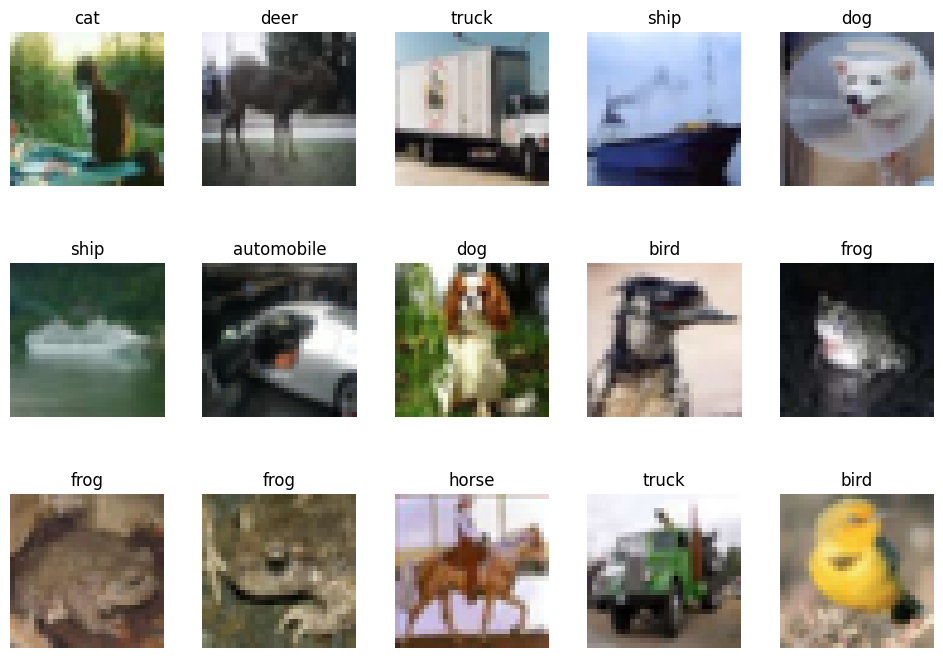

In [ ]:
# Assuming x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

<ipython-input-26-d25648d9713e>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(class_names, rotation = 90)


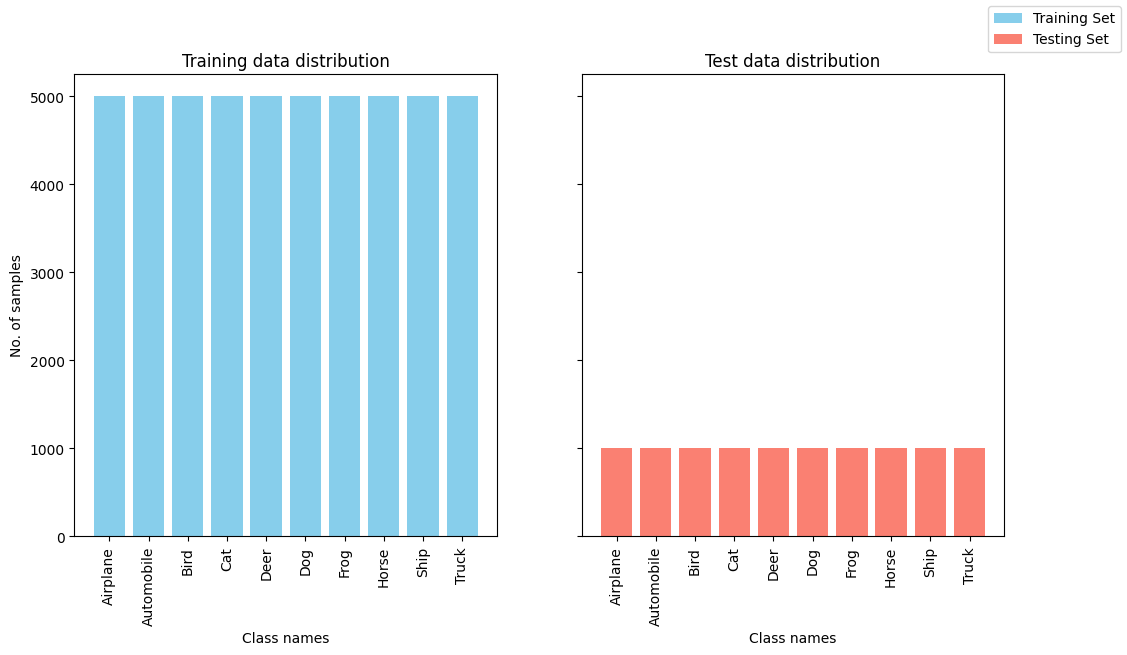

In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training data distribution')
axs[0].set_xlabel('Class names')
axs[0].set_ylabel('No. of samples')
axs[0].set_xticklabels(class_names, rotation = 90)
# Plot testing set distribution
axs[1].bar(class_names, test_counts, color='salmon')
axs[1].set_title('Test data distribution')
axs[1].set_xlabel('Class names')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'])

# plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
#This part is to describe the parametes, you can check below for a mode compact model version
num_classes=10

# Create the model
model = Sequential()
model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy (same means output size will be made same as input size)
        input_shape=(32, 32, 3),       # Input dimensions (height, width, channels)
        kernel_initializer='he_normal',# Weight initialization method
        activation='relu'              # Activation function
    )
)


model.add(BatchNormalization())      # Normalize activations for faster training
model.add(Dropout(0.2))              # Randomly drop 20% neurons to prevent overfitting

# Second Convolutional Layer in First Block
model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy
        kernel_initializer='he_normal', # Weight initialization method
        activation='relu'              # Activation function
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D())              # Reduce spatial dimensions by half (16x16)

# Second Convolutional Block - Doubled filters (64)
model.add(Conv2D(64,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Second Block
model.add(Conv2D(64,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())  # Further reduce spatial dimensions (8x8)


# Third Convolutional Block - Doubled filters (128)
model.add(Conv2D(128,
                 (5, 5),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Third Block
model.add(Conv2D(128,
                 (5, 5),
                 strides=1,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D())                   # Final spatial dimension reduction (4x4)

# Forth Convolutional Block - Doubled filters (256)
model.add(Conv2D(256,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Third Block
model.add(Conv2D(128,
                 (3, 3),
                 strides=1,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D())                   # Final spatial dimension reduction (4x4)

# Global Average Pooling to replace Flatten
# Reduces parameters and maintains spatial information
model.add(GlobalAveragePooling2D())

# Final Dropout before classification
model.add(Dropout(0.2))

# Output layer with softmax activation for 10-class classification
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]
#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
train_datagen = ImageDataGenerator()
(X_train, y_train) = cifar10.load_data()
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 8, 8, 128)           │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 4, 4, 256)           │           1,0

 Total params: 1,274,026 (4.86 MB)

 Trainable params: 1,272,874 (4.86 MB)

 Non-trainable params: 1,152 (4.50 KB)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 10000) + inhomogeneous part.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]
#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

NameError: name 'x_train1' is not defined

In [ ]:
num_classes=10

#Compact model version
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]


#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

NameError: name 'train_datagen' is not defined

# CNN-LSTM code

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

# Import necessary layers for building the neural network
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
# Import the Sequential model API for creating a linear stack of layers
from tensorflow.keras.models import Sequential
# Import optimizers for updating the model's weights during training
from tensorflow.keras.optimizers import SGD, Adam
# Import callbacks for training behavior control
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [16]:
data_ = pd.read_csv('/content/sample_data/RELIANCE.NS.csv', index_col='Date', parse_dates=['Date'])

# pd.read_csv(...): This line uses the read_csv function from the pandas library (imported as pd) to read data from a CSV (Comma-Separated Values) file.
# /content/drive/MyDrive/Colab Notebooks/TimesPro/RELIANCE.NS.csv: This is the file path specifying the location of the CSV file containing the data.
# index_col='Date': This argument sets the 'Date' column as the index (row labels) of the resulting DataFrame.
# parse_dates=['Date']: This tells pandas to interpret the 'Date' column as dates, making it easier to work with time-series data.
# data_: The data read from the CSV file is stored in a pandas DataFrame named data_. A DataFrame is a table-like data structure, like a spreadsheet.

row_with_nan = data_[data_.isnull().any(axis=1)].iloc[0]
print(row_with_nan)


print(f"Dataset shape before dropping NAN value rows: {data_.shape}")

data = data_.dropna(inplace=False)   #returns a new data frame

# data = data_.dropna(inplace=False): This is a crucial step where rows containing "Not a Number" (NaN) values are removed.
# dropna() is a pandas function that drops rows or columns with missing values.
# inplace=False means that the original data_ DataFrame is not modified. Instead, a new DataFrame named data is created without the NaN values.

print(f"Dataset shape after dropping NAN value rows: {data.shape}")

Open        NaN
High        NaN
Low         NaN
Close       NaN
Adj Close   NaN
Volume      NaN
Name: 1996-01-26 00:00:00, dtype: float64
Dataset shape before dropping NAN value rows: (6291, 6)
Dataset shape after dropping NAN value rows: (6164, 6)


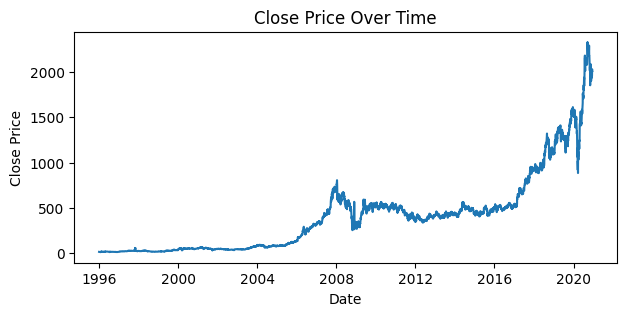

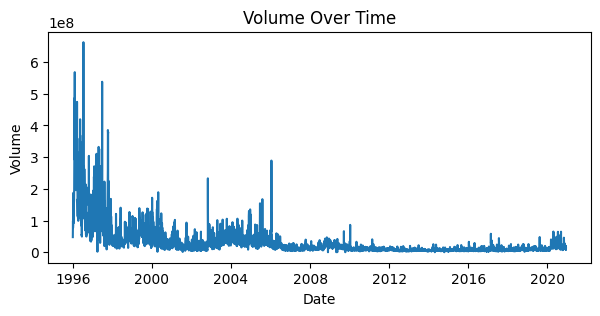

In [17]:
# Visualize the data using a line plot
plt.figure(figsize=(7, 3))
plt.plot(data['Close'])
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# You can also visualize other columns like Open, High, Low, Volume
# Example for Volume:
plt.figure(figsize=(7, 3))
plt.plot(data['Volume'])
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [18]:
data = data.filter(['Close'])

# Selecting the Target Variable: 'Close' column as the variable to predict

dataset = data.values

# converts the Pandas DataFrame (`data`) into a NumPy array
# NumPy arrays are more efficient for numerical operations, which are common when working with machine learning models. `dataset` now holds the closing price values as a 2D array.

scaler = MinMaxScaler(feature_range=(0,1))

# Creates an instance of `MinMaxScaler` from scikit-learn. This is a data preprocessing technique.  #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#`MinMaxScaler` scales the data so that all values fall within a specific range (in this case, 0 to 1).
# Scaling helps improve the performance of machine learning algorithms, particularly those that are sensitive to feature scaling, like neural networks.

scaled_data = scaler.fit_transform(dataset)

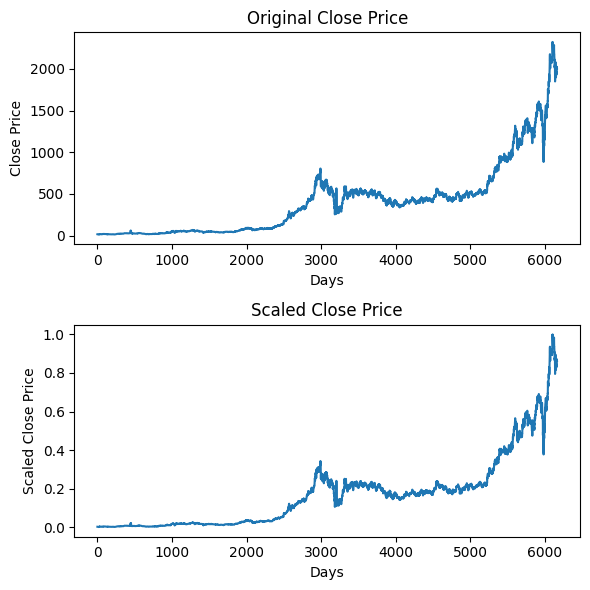

In [19]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(dataset)
plt.title('Original Close Price')
plt.xlabel('Days')
plt.ylabel('Close Price')

plt.subplot(2, 1, 2)
plt.plot(scaled_data)
plt.title('Scaled Close Price')
plt.xlabel('Days')
plt.ylabel('Scaled Close Price')

plt.tight_layout()
plt.show()

In [20]:
# Create the training data set

training_data_len = int(np.ceil( len(scaled_data) * .70 ))

print(training_data_len)

train_data = scaled_data[:int(training_data_len), :]

print(train_data.shape)

# Split the data into x_train and y_train data sets

x_train = []
y_train = []

# This loop iterates over the `train_data` to create training samples.
# `i` starts from 60, meaning the first 60 days are used as initial data.

for i in range(60, len(train_data)):

    # x_train: Stores previous 60 days' data as input features.

    x_train.append(train_data[i-60:i, 0])

    # y_train: Stores the closing price 1 day ahead as the target variable.

    y_train.append(train_data[i, 0])

# Example:
# For i = 60:
#   x_train will contain data from days 0 to 59 (60 data points)
#   y_train will contain data from days 60
# For i = 61:
#   x_train will contain data from days 1 to 60
#   y_train will contain data from days 61
# And so on...


# Convert the x_train and y_train to numpy arrays for easier handling.
x_train, y_train = np.array(x_train), np.array(y_train)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

4315
(4315, 1)
x_train shape: (4255, 60)
y_train shape: (4255,)
(4255, 60, 1)
(4255,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 80)              │          26,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,491 (205.04 KB)

 Trainable params: 52,491 (205.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - loss: 0.0020 - val_loss: 2.6891e-04 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 7.1007e-05 - val_loss: 8.3254e-05 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 5.5789e-05 - val_loss: 7.0574e-05 - learning_rate: 0.0010
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 4.3745e-05 - val_loss: 5.5288e-05 - learning_rate: 0.0010
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 4.4068e-05 - val_loss: 4.4642e-05 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 3.6436e-05 - val_loss: 1.2560e-04 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 4.4788e-05 - val_loss: 3.2611e-05 - learning_rate: 0.0010
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 3.4680e-05 - val_loss: 3.7943e-05 - learning_rate: 2.0000e-04
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━

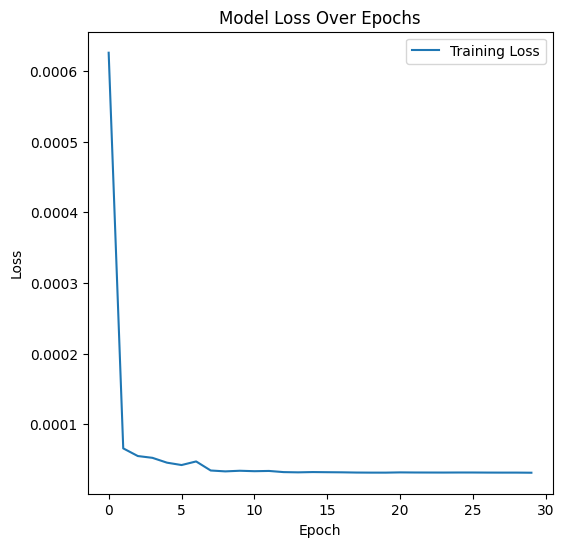

In [21]:
model = Sequential()  # Create a Sequential model, which is a linear stack of layers
model.add(LSTM(80, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add the first LSTM layer
# - 80 units: The LSTM layer has 80 memory cells
# - return_sequences=True: This LSTM layer will return the entire sequence, allowing for stacking with another LSTM layer
# - input_shape=(x_train.shape[1], 1): Specifies the shape of the input data. Here, it's expected to be (time_steps, features), where features is 1

model.add(LSTM(units=50, return_sequences=False))

# Add the second LSTM layer
# - 50 units: This LSTM layer has 50 memory cells
# - return_sequences=False: This LSTM layer will return only the last output in the output sequence, flattening the output for the Dense layer

model.add(Dense(units=1, activation='relu'))

# Add a Dense layer for the final prediction
# - units=1: The output layer has 1 unit for regression or binary classification
# - activation='relu': Use ReLU activation for non-linearity in the output

model.summary()

# Compile the model
# - optimizer=Adam(learning_rate=0.001): Use Adam optimizer with a learning rate of 0.001 for adaptive learning
# - loss='mean_squared_error': Use Mean Squared Error as the loss function for regression tasks

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define callbacks for training
# Early Stopping: This callback will stop training when the model's performance on the validation set starts deteriorating

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,                 # Number of epochs to wait before stopping if validation loss does not improve
                               restore_best_weights=True    # Restore model weights from the epoch with the best performance
                               )

# Reduce Learning Rate on Plateau: This callback will decrease the learning rate if the validation loss stops improving

reduce_lr = ReduceLROnPlateau(monitor='val_loss',   # Monitor validation loss
                              factor=0.2,           # Reduce the learning rate by 20% when triggered
                              patience=5,           # Number of epochs to wait before reducing learning rate
                              min_lr=0.00001)        # Minimum learning rate to allow

# Train the model

history = model.fit(x_train, y_train,       # Training data, Training labels
                    batch_size=32,          # Number of samples per gradient update
                    epochs=100,              # Maximum number of epochs to train
                    validation_split=0.2,   # Use 20% of the training data for validation
                    callbacks=[early_stopping, reduce_lr],  # Apply the defined callbacks during training
                    verbose=1)                  # Enable verbose output for progress bar

# Plot the loss over epochs

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
(1789, 1)
(1789, 1)
The root mean squared error is 69.5285089968176.


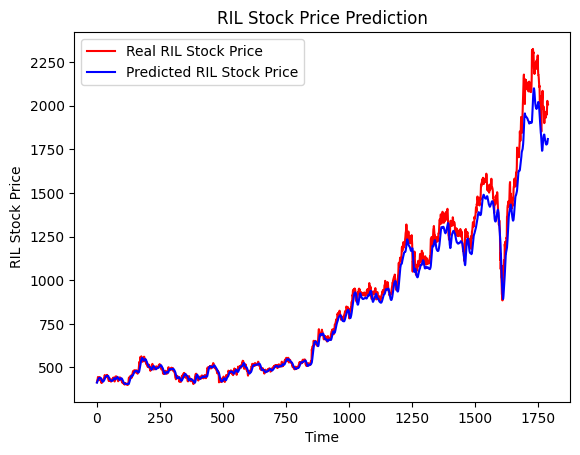

In [22]:
# Define a function to calculate and print RMSE

def return_rmse(test,predicted):

    # Calculate the Root Mean Squared Error (RMSE) between test and predicted values

    rmse = math.sqrt(mean_squared_error(test, predicted))

    print("The root mean squared error is {}.".format(rmse))

# Create the testing data set
# Slice the scaled data from the end of the training set to the end of the dataset

test_data = scaled_data[training_data_len: , :]

# Extract the original dataset values for testing, starting from 60 time steps after the training data ends
y_test_org = dataset[training_data_len+60:, :]

# Prepare the input data for the model's predictions
x_test = []

# Loop through the test data, creating sequences of the last 60 time steps as input for each prediction
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the list of sequences into a numpy array for model input
x_test = np.array(x_test)
# Reshape the input data to fit the LSTM model's expected input shape (samples, time steps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Use the trained model to make predictions on the test data
predictions_scaled = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
predictions_org = scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)

# Calculate and print the RMSE between the original test values and the model's predictions
return_rmse(y_test_org,predictions_org)

def plot_predictions(test,predicted):
    plt.plot(y_test_org, color='red',label='Real RIL Stock Price')
    plt.plot(predictions_org, color='blue',label='Predicted RIL Stock Price')
    plt.title('RIL Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('RIL Stock Price')
    plt.legend()
    plt.show()
plot_predictions(y_test_org,predictions_org)

In [26]:

# Load the historical stock data from a CSV file with 'Date' as the index

data_ = pd.read_csv('/content/sample_data/RELIANCE.NS.csv', index_col='Date', parse_dates=['Date'])

# Print the column names of the dataset
print(data_.keys())

# Remove any rows with missing values to ensure data integrity
data = data_.dropna(inplace=False)  # This returns a new DataFrame

# Select input features for the model (Open, High, and Volume)
input_data = data[['Open', 'High', 'Volume']]

# Print the column names of the input features
print(input_data.keys())

# Extract the 'Close' prices as the output data
output_data = data[['Close']].values

# Initialize separate scalers for input and output features
input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the input features to a range between 0 and 1
scaled_data = input_scaler.fit_transform(input_data)

# Normalize the output (Close prices) separately
scaled_output = output_scaler.fit_transform(output_data)

# Define the percentage of data to use for training
training_data_len = int(np.ceil(len(scaled_data) * 0.70))

# Split the data into training and test sets
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

# Initialize lists to store sequences for training and testing
x_train, x_test, y_train, y_test, y_test_org = [], [], [], [], []
seq_length = 60  # Number of time steps to look back

# Create sequences for training data
for i in range(len(train_data) - seq_length - 4):
    # Append sequences of 60 time steps for input
    x_train.append(train_data[i:(i + seq_length)])
    # Append the next 5 time steps as output for prediction (since we want to predict 5 future close prices)
    y_train.append(scaled_output[(i + seq_length):(i + seq_length + 5)])

# Create sequences for test data
for i in range(len(test_data) - seq_length - 4):
    # Append sequences of 60 time steps for input
    x_test.append(test_data[i:(i + seq_length)])
    # Append the next 5 time steps as scaled output for prediction
    y_test.append(scaled_output[training_data_len + i + seq_length:
                                training_data_len + i + seq_length + 5])
    # Append the next 5 time steps as original output for comparison
    y_test_org.append(output_data[training_data_len + i + seq_length:
                                  training_data_len + i + seq_length + 5])

# Convert lists to numpy arrays for model input
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_org = np.array(y_test_org)

# Print shapes for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_test_org shape:", y_test_org.shape)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Volume'], dtype='object')
x_train shape: (4251, 60, 3)
y_train shape: (4251, 5, 1)
x_test shape: (1785, 60, 3)
y_test shape: (1785, 5, 1)
y_test_org shape: (1785, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 80)              │          26,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,335 (208.34 KB)

 Trainable params: 53,335 (208.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0031 - val_loss: 1.6030e-04 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 7.9676e-05 - val_loss: 7.5835e-05 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 7.5785e-05 - val_loss: 8.5387e-05 - learning_rate: 0.0010
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 7.0106e-05 - val_loss: 1.4790e-04 - learning_rate: 0.0010
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 6.5159e-05 - val_loss: 1.6816e-04 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 7.5099e-05 - val_loss: 7.4459e-05 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 6.6462e-05 - val_loss: 6.0501e-05 - learning_rate: 2.0000e-04
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 5.1433e-05 - val_loss: 5.6582e-05 - learning_rate: 2.0000e-04
Epoch 9/100
107/107 ━━━━━━━━━━━

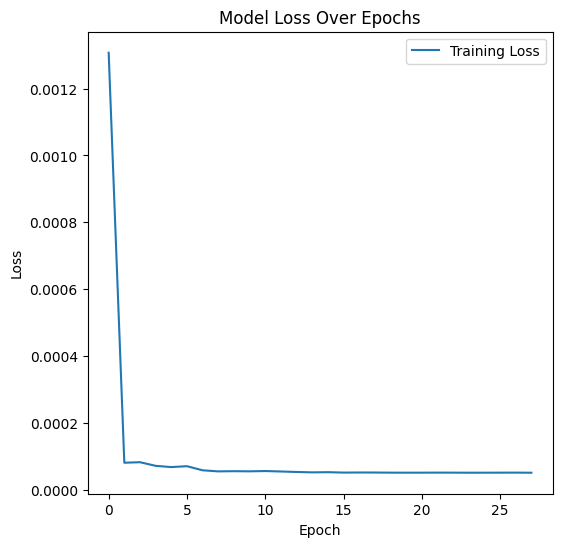

In [27]:
# Initialize a Sequential model - a linear stack of layers
model = Sequential()

# First LSTM Layer
model.add(LSTM(
    units=80,  # Number of LSTM units/neurons in this layer
    return_sequences=True,  # Return full sequence for next LSTM layer
    input_shape=(x_train.shape[1], 3)  # Input shape: (sequence_length, number_of_features)
    # sequence_length = 60 time steps
    # number_of_features = 3 (Open, High, Volume)
))

# Second LSTM Layer
model.add(LSTM(
    units=50,  # Number of LSTM units/neurons
    return_sequences=False  # Return only the last output (many-to-one architecture)
    # This is needed because we want to connect to a Dense layer next
))

# Output Dense Layer
model.add(Dense(
    units=5,  # Output 5 values (predicting next 5 time steps)
    activation='relu'  # ReLU activation for positive stock price predictions
))

# Display model architecture summary
model.summary()


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [28]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

predictions_scaled = model.predict(x_test)
print(predictions_scaled.shape)
predictions_org = output_scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)
return_rmse(y_test_org[:,:,0],predictions_org)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
(1785, 5)
(1785, 5, 1)
(1785, 5)
The root mean squared error is 122.4019157128604.


In [ ]:
model = Sequential()
model.add(LSTM(200, return_sequences=False, input_shape=(x_train.shape[1], 3)))
#model.add(Dropout(0.3))
# model.add(LSTM(units=20, return_sequences=False))
# model.add(Dropout(0.3))
#model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=5, activation='relu'))
model.summary()


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 200)                 │         163,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,205 (641.43 KB)

 Trainable params: 164,205 (641.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 0.0013 - val_loss: 2.6496e-04 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 7.3911e-05 - val_loss: 6.9703e-05 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 8.6397e-05 - val_loss: 5.3047e-05 - learning_rate: 0.0010


In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

predictions_scaled = model.predict(x_test)
print(predictions_scaled.shape)
predictions_org = output_scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)
return_rmse(y_test_org[:,:,0],predictions_org)